In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, Image

from matplotlib import cm
import geopandas as gp
import seaborn as sns
import bezier

In [12]:
rc('animation', html='html5')

In [13]:
df = pd.read_json("temp/stats.json")

df["attacker"] = df["options"].apply(lambda x: x[0]["text"])
df["defender"] = df["options"].apply(lambda x: x[1]["text"])
df["attack"] = df["options"].apply(lambda x: x[0]["voter_count"])
df["defense"] = df["options"].apply(lambda x: x[1]["voter_count"])

df = df[["attacker", "defender", "attack", "defense"]]
df.head()

,attacker,defender,attack,defense
0,Casalecchio di Reno,Sasso Marconi,2,2
1,Baricella,Minerbio,5,1
2,Grizzana Morandi,San Benedetto Val di Sambro,2,2
3,Galliera,Pieve di Cento,0,1
4,Ozzano dell'Emilia,Medicina,2,3


In [14]:
def assign_color(df):
    reds = sns.color_palette("Reds", n_colors=6)
    greens = sns.color_palette("Greens", n_colors=6)
    
    attack_max = df.attack.max()
    defense_max = df.defense.max()

    def get_color(row, n_colors=6):
        if row.r > 0:
            return reds[int(row.attack / attack_max * (n_colors - 1))]
        else:
            return greens[int(row.defense / defense_max * (n_colors - 1))]

    df = df.assign(r=df.attack - df.defense)
    return df.apply(lambda row: get_color(row), axis=1)

In [15]:
df["colors"] = assign_color(df)
df.head()

,attacker,defender,attack,defense,colors
0,Casalecchio di Reno,Sasso Marconi,2,2,"(0.7371472510572856, 0.895517108804306, 0.7108..."
1,Baricella,Minerbio,5,1,"(0.9882352941176471, 0.6866743560169165, 0.577..."
2,Grizzana Morandi,San Benedetto Val di Sambro,2,2,"(0.7371472510572856, 0.895517108804306, 0.7108..."
3,Galliera,Pieve di Cento,0,1,"(0.8828143021914648, 0.9546943483275664, 0.862..."
4,Ozzano dell'Emilia,Medicina,2,3,"(0.7371472510572856, 0.895517108804306, 0.7108..."


In [16]:
bolo = pd.read_pickle("config/bologna.pickle")
coords = bolo.geometry.centroid.map(lambda xy: (xy.x, xy.y))

In [17]:
def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity='random'):
    # Get nodes into np array
    edges = np.array(list(G.edges()))
    l = edges.shape[0]

    if polarity == 'random':
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l) == 0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(np.mod(np.vectorize(hash)(edges[:, 0]) + np.vectorize(hash)(edges[:, 1]), 2) == 0, -1, 1)
    
    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse = True)
    coords = np.array([pos[x] for x in u])[inv].reshape([edges.shape[0], 2, edges.shape[1]])
    coords_node1 = coords[:, 0, :]
    coords_node2 = coords[:, 1, :]
    
    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:, 0] > coords_node2[:, 0]
    coords_node1[should_swap], coords_node2[should_swap] = coords_node2[should_swap], coords_node1[should_swap]
    
    # Distance for control points
    # dist = dist_ratio * np.sqrt(np.sum((coords_node1 - coords_node2) ** 2, axis=1))
    dist = (0.3 * np.random.sample(coords_node1.shape[0]) + 0.05) * np.sqrt(np.sum((coords_node1 - coords_node2) ** 2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[: ,1] - coords_node1[:,1]) / (coords_node2[:,0] - coords_node1[:, 0])
    m2 = -1 / m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist / np.sqrt(1 + m1 ** 2)
    v1 = np.array([np.ones(l), m1])
    coords_node1_displace = coords_node1 + (v1 * t1).T
    coords_node2_displace = coords_node2 - (v1 * t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist / np.sqrt(1 + m2 ** 2)
    v2 = np.array([np.ones(len(edges)), m2])
    coords_node1_ctrl = coords_node1_displace + (rnd * v2 * t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd * v2 * t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array([coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2])

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:, i, :].T
        curveplots.append(bezier.Curve(nodes, degree=2).evaluate_multi(np.linspace(0, 1, bezier_precision)).T)
      
    # Return an array of these curves
    curves = np.array(curveplots)
    return curves

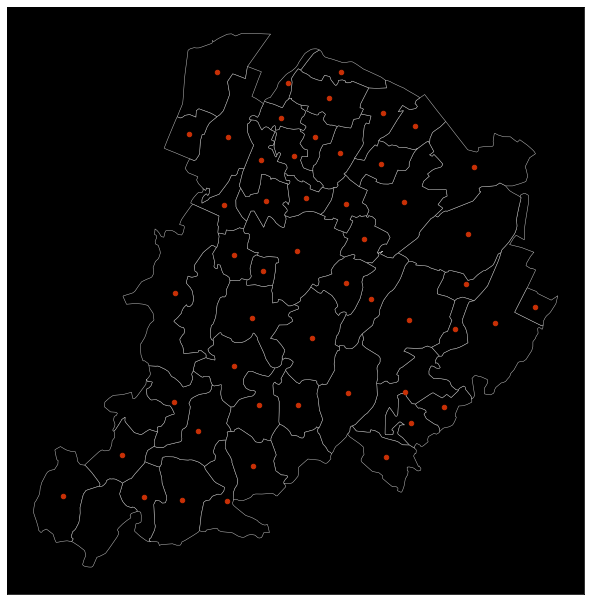

In [19]:
fig, ax = plt.subplots(figsize=(1920 / 100, 1080 / 100))

G = nx.from_pandas_edgelist(df, source="attacker", target="defender", edge_attr=True, create_using=nx.MultiDiGraph)
coords = bolo.geometry.centroid.map(lambda xy: (xy.x, xy.y))

curves = curved_edges(G, coords)
lc = LineCollection(curves, colors=df.colors, alpha=0, lw=2)

ax.set_facecolor("k")
bolo.plot(ax=ax, fc="k", ec="#bfbfbf", lw=.5, figsize=(1920 / 100, 1080 / 100))
c = ax.add_collection(lc)
nx.draw_networkx_nodes(G, coords, node_size=20, node_color="#c93006", ax=ax)


def animate(i):
    colors = lc.get_colors()
    colors[:i, 3] = 0.55
    lc.set_facecolor(colors)
    return lc,

In [20]:
animation = FuncAnimation(fig, animate, frames=len(df), blit=True)
animation

In [143]:
animation.save("network.gif", writer="imagemagick")